<a href="https://colab.research.google.com/github/Anushka-Anjali/Dementia-Detection-with-Activation-Function/blob/main/Dementia_detection_Activation_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Making Imports
#sys isused for system level operations
 #(modifying the path that python searches for modules)
import os, sys #functions to interact with os (reading/writing to file system)

import matplotlib.pyplot as plt #functions for creating static, animated, and
  #interactive visualizations. widely used for plotting graphs

import numpy as np #numerical computation. provides support for arrays,
  #matrices, math functions to operate on these data structures

import PIL #Python Imaging Library (modern fork named Pillow commonly used).
  #provides capabilities for opening, manipulating, and saving many different
  #image file formats

import tensorflow as tf #lib for ML and DL comprehensive ecosystem of tools,
  #libraries, and community resources for building and deploying machine
  #learning models.

from tensorflow import keras #Keras is high level NN API - allows for easy
  #and fast prototyping, state-of-the-art research, and production.

from tensorflow.keras import layers #contains a wide range of neural network
  #layers (like Dense, Conv2D, LSTM, etc.) that can be used to construct models.

from tensorflow.keras.models import Sequential #linear stack of layers. builds
  #simple neural networks by stacking layers sequentially

from pathlib import Path #class for handling filesystem paths with semantics
  #appropriate for different operating systems. more intuitive compared to 'os'

import random #useful for generating random numbers, selecting random elements,
  #shuffling data, etc

import cv2 #OpenCV - common infra for comp vision, accelerates the use of
  #machine perception in commercial products - used for image processing, video
  #capture and analysis

import warnings #handles warning and allows displpay, filter or ignore warnings
warnings.filterwarnings("ignore")

In [3]:
#import drive module from google.colab. provides tools for interacting with
  #Google Drive within a Colab notebook.
from google.colab import drive
drive.mount('/content/drive') #lets us access Drive files directly from colab

Mounted at /content/drive


In [4]:
#Classes in dataset
total_classes = os.listdir("/content/drive/MyDrive/Internship IISc/Datasets/threedataset")
total_classes
#returns a list of the names of the entries in the directory given by path

['Mild', 'Non', 'Very Mild']

In [5]:
#Total number of images per class.
images_path = Path("/content/drive/MyDrive/Internship IISc/Datasets/threedataset") #set up path
#iterate over total classes and then count and print images
for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Mild = 896 images
* Non = 896 images
* Very Mild = 896 images


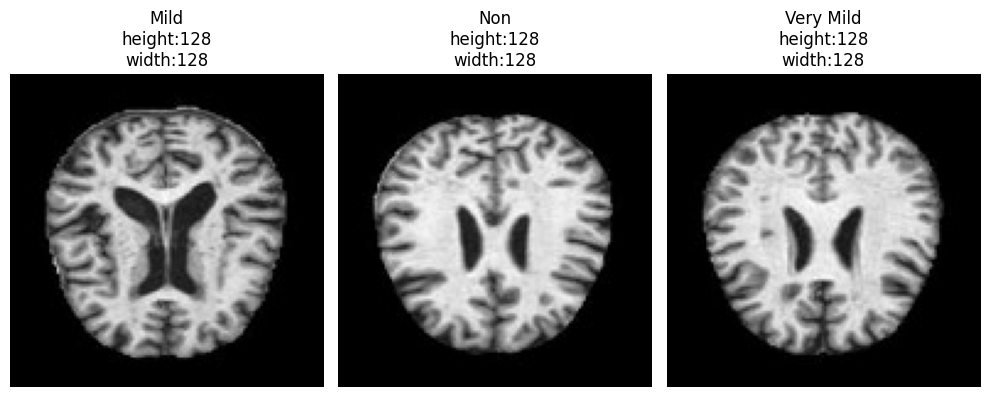

In [6]:
# Let's display 1 random image per class.

fig,ax = plt.subplots(1,3,figsize=(10,4)) #1 row, 4 col, size of fig
ax = ax.flat #flattens the array of axes objects for easy iteration.

#iterating over classes
for i,c in enumerate(total_classes):
  #selecting and loading images
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape #extracts image dimensions
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [7]:
batch_size = 32 #The number of samples (images) that will be processed together
  # in one pass (batch)

img_height = 180 #(number of pixels vertically) to which all input images will
  #be resized.

img_width = 180 #(number of pixels horizontally) to which all input images will
  # be resized

In [8]:
#generate dataset from image files in a directory
#images_path is the path to the directory containing the image data
#validation split => 20% data used for val (train and val split)
#subset training => ensures that only the training portion (80% in this case)
  #is returned.
#seed for random number generator - Setting a seed ensures that the data is
  #split into training and validation subsets in a reproducible way.
#image_size - resizes image - ensures that all images fed into the model have
  #the same dimensions.
#batch size- no. of images in each batch (here 32) - Batching is crucial for
  #efficient training on GPUs and for gradient computation in deep learning
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 2688 files belonging to 3 classes.
Using 2151 files for training.


In [9]:
#same as the above segement - this time for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2688 files belonging to 3 classes.
Using 537 files for validation.


In [10]:
#retrieves and prints the names of the classes (subdirectories) from the
  #training dataset.
class_names = train_ds.class_names
print(class_names)

['Mild', 'Non', 'Very Mild']


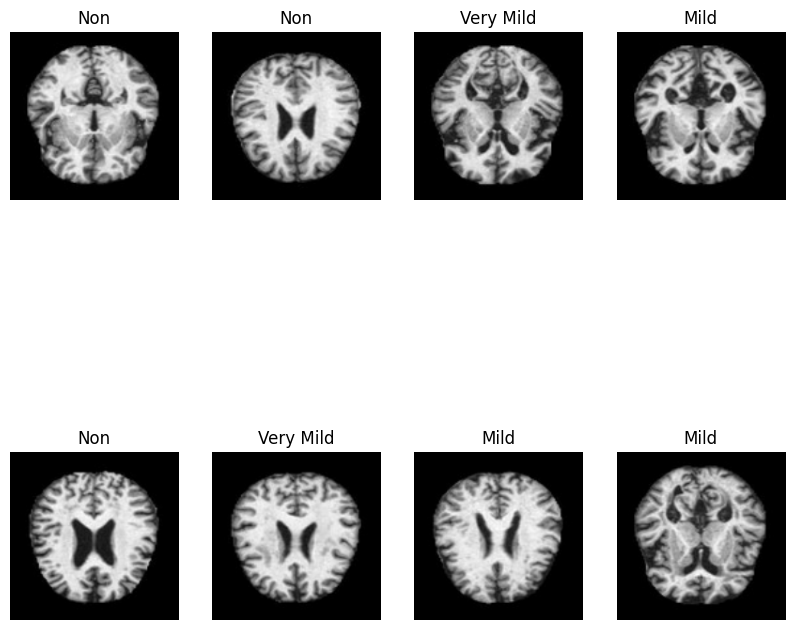

In [11]:
# Vizualizing the data as a batch of images from the training dataset using
  #matplotlib
# resize images and iterate though the dataset to display images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8): #loops over the first 8 images in a batch
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
#iterates through the dataset, retrieves a batch of images and labels
  #and prints the output shapes of the image and label batches
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [13]:
#Configure the data for higher performance - enhances the performance of the
  #training and validation datasets by using caching, shuffling, and prefetching

AUTOTUNE = tf.data.AUTOTUNE #define autotune - constant that allows runtime
  #to automatically tune the buffer sizes dynamically

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  #enhance the training dataset - Caches the dataset in memory after it’s
  #loaded from disk - Shuffles the dataset with a buffer size of 1000
  #Prefetches the next batch while the current batch is being processed

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  #enhance the validation dataset - caches teh validation dataset in the memory
  #Prefetches the next batch of validation data while the current batch is
  #being evaluated.

In [14]:
#Standardizing the dataset
#normalizes the pixel values of the images in the training dataset so that they
  #fall within the range [0, 1] instead of the default range [0, 255]
normalization_layer = layers.Rescaling(1./255) #rescaling pixel values

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#creates a new dataset where each image has been normalized.
#applies the normalization layer to each image in training
#lambda function applies normalization to image tensor and leaves label same

#iterating over normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0] #accessing the first image

# Notice the pixel values are now in '[0,1]'
print(np.min(first_image), np.max(first_image))

0.0 0.95838207


In [15]:
num_classes = len(class_names)

#Adding Dropout Layer - By adding the Dropout layer, the model becomes more
  #robust by reducing the risk of overfitting, which often results in better
  #performance on unseen data. it is a regularization technique
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])
# loss function - Sparse categorical crossentropy to handle multi-class
  #classification.
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
model.summary() #Prints a summary of the model's architecture, including the
  #layers and the number of parameters.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
#Training the model
epochs = 7 #specifies the number of complete passes through the training set
#model.fit is used to train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/7
68/68 [==============================] - 124s 2s/step - loss: 0.9461 - accuracy: 0.5342 - val_loss: 0.7803 - val_accuracy: 0.6499
Epoch 2/7
68/68 [==============================] - 43s 631ms/step - loss: 0.6836 - accuracy: 0.6834 - val_loss: 0.7396 - val_accuracy: 0.6629
Epoch 3/7
68/68 [==============================] - 44s 645ms/step - loss: 0.5552 - accuracy: 0.7722 - val_loss: 0.4849 - val_accuracy: 0.7970
Epoch 4/7
68/68 [==============================] - 43s 634ms/step - loss: 0.3708 - accuracy: 0.8517 - val_loss: 0.3349 - val_accuracy: 0.8641
Epoch 5/7
68/68 [==============================] - 43s 633ms/step - loss: 0.2076 - accuracy: 0.9242 - val_loss: 0.2594 - val_accuracy: 0.8939
Epoch 6/7
68/68 [==============================] - 42s 625ms/step - loss: 0.1308 - accuracy: 0.9577 - val_loss: 0.2077 - val_accuracy: 0.9143
Epoch 7/7
68/68 [==============================] - 42s 622ms/step - loss: 0.0970 - accuracy: 0.9647 - val_loss: 0.2130 - val_accuracy: 0.9143


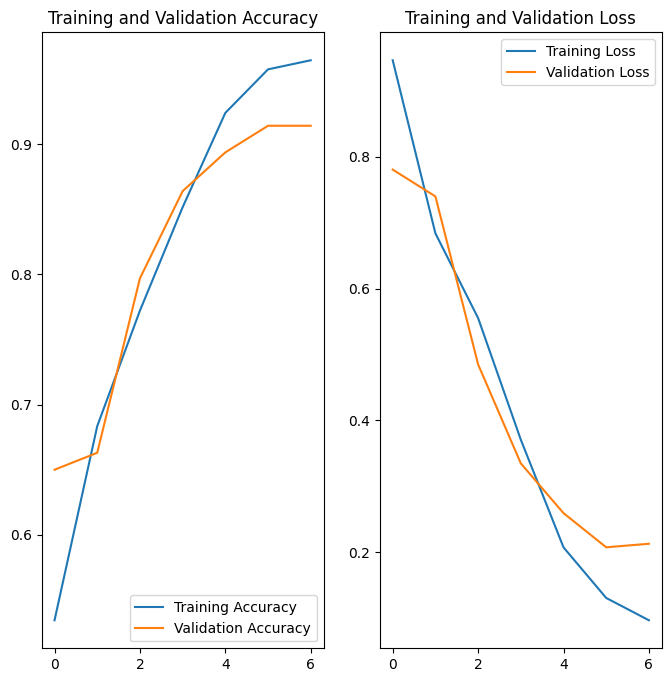

In [17]:
#Visualizing the results
#dictionary containing the values of the metrics specified during model
  #compilation (accuracy and loss), both for training and validation sets.
acc = history.history['accuracy'] #training accuracy
val_acc = history.history['val_accuracy'] #validation accuracy

loss = history.history['loss'] #training loss
val_loss = history.history['val_loss'] #validation loss

epochs_range = range(epochs) #creates a range object for the number of epochs,
  #which will be used for plotting.

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

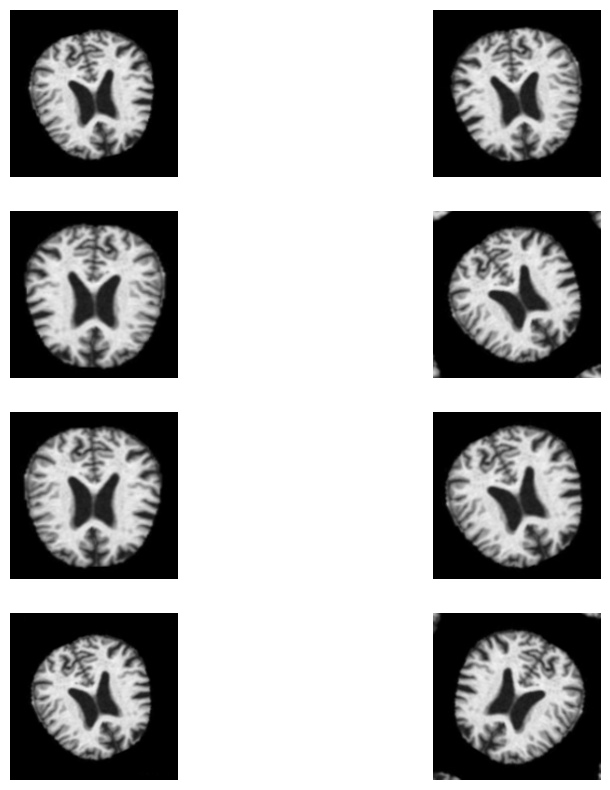

In [18]:
#Data Augmentation
#A Sequential model is used to stack multiple layers together.
#RandomFlip - Randomly flips images horizontally
#RandomRotation - Randomly rotates images by up to 10% (0.1 radians).
#RandomZoom - Randomly zooms into images by up to 10%
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

plt.figure(figsize=(10, 10))
#Takes one batch of images from the training dataset.
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
#Saving the model - Save the Keras model as an HDF5 file
#save the entire model, including the architecture, weights, and training
  #configuration, in a single file.
model.save("alzeihmer_model2.h5")

In [20]:
model = tf.keras.models.load_model('alzeihmer_model2.h5')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

1/1 [==============================] - 0s 143ms/step
(1, 90, 90, 16)


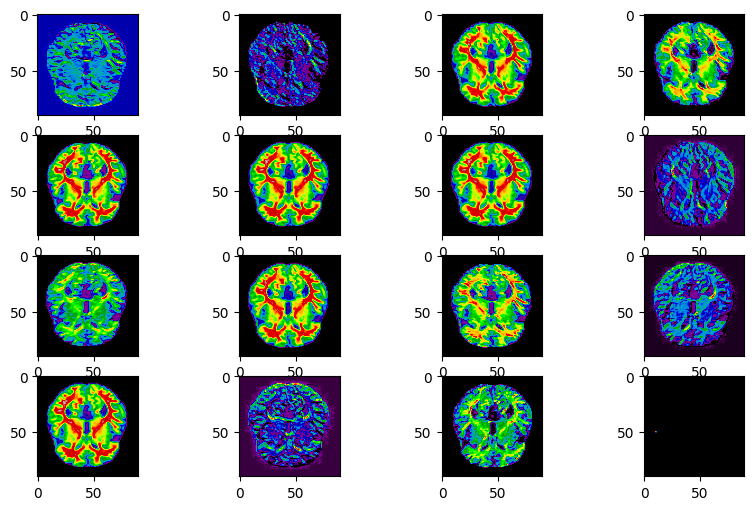

In [21]:
layer_outputs = [layer.output for layer in model.layers]
#activation_model = model(inputs=model.input, outputs=layer_outputs)

# Assuming 'model' is your pre-existing model
inputs = model.input  # Get the input layer of the original model

# Define the output layers you want to extract
# For example, if you want to get the output of the second last layer
#last_layer_output = model.get_layer(name='dense_1').output
# Replace 'name_of_the_last_layer' with the actual name of the layer whose output you want

from tensorflow.keras.models import Model
from PIL import Image

# Create a new model that takes the original model's input and outputs the desired layer(s)
activation_model = Model(inputs=inputs, outputs=layer_outputs)

arr = Image.open('/content/drive/MyDrive/Internship IISc/Datasets/TestDataUnclassed/Copy of mild_319.jpg')
arr_rgb = arr.convert('RGB')
resized_arr = arr_rgb.resize((180, 180))
resized_arr1 = np.array(resized_arr)

#if resized_arr1.shape[2] == 4:  # Check if the image has an alpha channel (RGBA)
 #   resized_arr1 = resized_arr1[:, :, :3]  # Remove the alpha channel

activations = activation_model.predict(resized_arr1.reshape(1,180,180,3))

def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    print(activation.shape)
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='nipy_spectral')
            activation_index += 1

#### conv2D filters ####
import matplotlib.pyplot as plt
display_activation(activations, 4, 4, 2)

In [22]:
activations[0].shape,activations[1].shape,activations[2].shape,activations[3].shape,activations[4].shape, activations[5].shape, activations[6].shape

((1, 180, 180, 3),
 (1, 180, 180, 16),
 (1, 90, 90, 16),
 (1, 90, 90, 32),
 (1, 45, 45, 32),
 (1, 45, 45, 64),
 (1, 22, 22, 64))

1/1 [==============================] - 0s 123ms/step
Layer 0 output shape: (1, 180, 180, 3)
Layer 1 output shape: (1, 180, 180, 16)
Layer 2 output shape: (1, 90, 90, 16)
Layer 3 output shape: (1, 90, 90, 32)
Layer 4 output shape: (1, 45, 45, 32)
Layer 5 output shape: (1, 45, 45, 64)
Layer 6 output shape: (1, 22, 22, 64)
Layer 7 output shape: (1, 22, 22, 64)
Layer 8 output shape: (1, 30976)
Layer 9 output shape: (1, 128)
Layer 10 output shape: (1, 3)


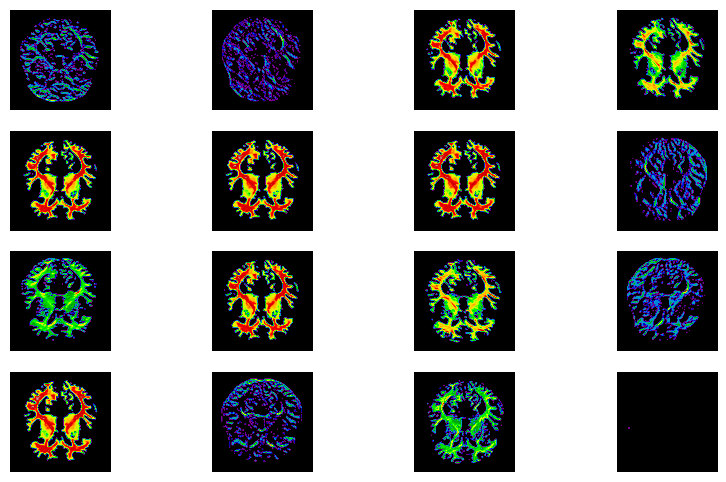

In [23]:
layer_outputs = [layer.output for layer in model.layers]
#activation_model = model(inputs=model.input, outputs=layer_outputs)

# Assuming 'model' is your pre-existing model
inputs = model.input  # Get the input layer of the original model

# Define the output layers you want to extract
# For example, if you want to get the output of the second last layer
#last_layer_output = model.get_layer(name='dense_1').output
# Replace 'name_of_the_last_layer' with the actual name of the layer whose output you want

from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Create a new model that takes the original model's input and outputs the desired layer(s)
activation_model = Model(inputs=inputs, outputs=layer_outputs)

arr = Image.open('/content/drive/MyDrive/Internship IISc/Datasets/TestDataUnclassed/Copy of mild_319.jpg')
arr_rgb = arr.convert('RGB')
resized_arr = arr_rgb.resize((180, 180))
resized_arr1 = np.array(resized_arr)

#if resized_arr1.shape[2] == 4:  # Check if the image has an alpha channel (RGBA)
#    resized_arr1 = resized_arr1[:, :, :3]  # Remove the alpha channel

activations = activation_model.predict(resized_arr1.reshape(1, 180, 180, 3))
for idx, activation in enumerate(activations):
    print(f'Layer {idx} output shape: {activation.shape}')

'''
def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    print(activation.shape)
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='nipy_spectral')
            activation_index += 1
'''

def display_highlighted_pixels(activation, col_size, row_size):
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 2.5, col_size * 1.5))

    for row in range(row_size):
        for col in range(col_size):
            act = activation[0, :, :, activation_index]
            mask = np.zeros_like(act)
            threshold = np.mean(act) + np.std(act)  # Adjust threshold as needed
            mask[act > threshold] = act[act > threshold]
            ax[row][col].imshow(mask, cmap='nipy_spectral')
            ax[row][col].axis('off')
            activation_index += 1
            if activation_index >= activation.shape[-1]:
                break

# Display activations for a specific layer (e.g., first conv layer)
layer_index = 1  # Change this to the index of the desired layer
display_highlighted_pixels(activations[layer_index], 4, 4)
plt.show()

1/1 [==============================] - 0s 79ms/step
Layer 0 output shape: (1, 180, 180, 3)
Layer 1 output shape: (1, 180, 180, 16)
Layer 2 output shape: (1, 90, 90, 16)
Layer 3 output shape: (1, 90, 90, 32)
Layer 4 output shape: (1, 45, 45, 32)
Layer 5 output shape: (1, 45, 45, 64)
Layer 6 output shape: (1, 22, 22, 64)
Layer 7 output shape: (1, 22, 22, 64)
Layer 8 output shape: (1, 30976)
Layer 9 output shape: (1, 128)
Layer 10 output shape: (1, 3)


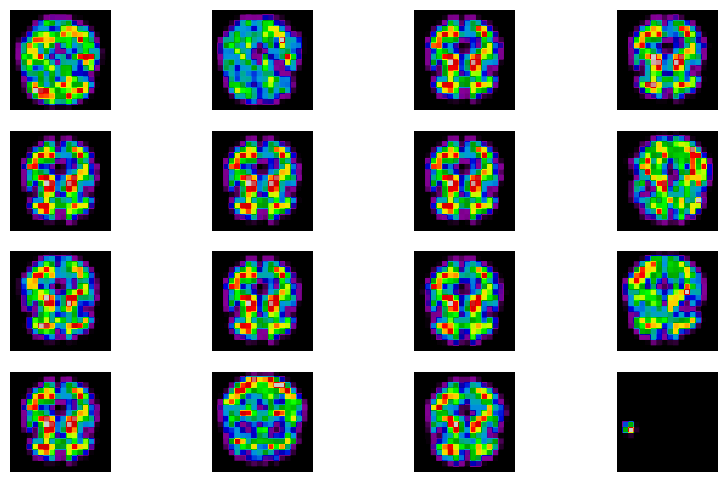

In [24]:
layer_outputs = [layer.output for layer in model.layers]
#activation_model = model(inputs=model.input, outputs=layer_outputs)

# Assuming 'model' is your pre-existing model
inputs = model.input  # Get the input layer of the original model

# Define the output layers you want to extract
# For example, if you want to get the output of the second last layer
#last_layer_output = model.get_layer(name='dense_1').output
# Replace 'name_of_the_last_layer' with the actual name of the layer whose output you want

from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Create a new model that takes the original model's input and outputs the desired layer(s)
activation_model = Model(inputs=inputs, outputs=layer_outputs)

arr = Image.open('/content/drive/MyDrive/Internship IISc/Datasets/TestDataUnclassed/Copy of mild_319.jpg')
arr_rgb = arr.convert('RGB')
resized_arr = arr_rgb.resize((180, 180))
resized_arr1 = np.array(resized_arr)

#if resized_arr1.shape[2] == 4:  # Check if the image has an alpha channel (RGBA)
#    resized_arr1 = resized_arr1[:, :, :3]  # Remove the alpha channel

activations = activation_model.predict(resized_arr1.reshape(1, 180, 180, 3))
for idx, activation in enumerate(activations):
    print(f'Layer {idx} output shape: {activation.shape}')

'''
def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    print(activation.shape)
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='nipy_spectral')
            activation_index += 1
'''

def display_highlighted_pixels(activation, col_size, row_size, resize_factor=0.1):
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 2.5, col_size * 1.5))

    for row in range(row_size):
        for col in range(col_size):
            if activation_index >= activation.shape[-1]:
                break

            act = activation[0, :, :, activation_index]
            mask = np.zeros_like(act)
            threshold = np.mean(act) + np.std(act)  # Adjust threshold as needed
            mask[act > threshold] = act[act > threshold]

            # Resize the mask to lower resolution
            low_res_mask = resize(mask, (int(mask.shape[0] * resize_factor), int(mask.shape[1] * resize_factor)), anti_aliasing=True)
            # Upscale back to the original size for pixelated effect
            low_res_mask = resize(low_res_mask, mask.shape, anti_aliasing=False, order=0)

            ax[row][col].imshow(low_res_mask, cmap='nipy_spectral')
            ax[row][col].axis('off')
            activation_index += 1

# Display activations for a specific layer (e.g., first conv layer)
layer_index = 1  # Change this to the index of the desired layer
display_highlighted_pixels(activations[layer_index], 4, 4, resize_factor=0.1)
plt.show()

Model layers:
rescaling_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
dropout
flatten
dense
dense_1
1/1 [==============================] - 0s 88ms/step
rescaling_1 (None, 180, 180, 3)
conv2d (None, 180, 180, 16)
max_pooling2d (None, 90, 90, 16)
conv2d_1 (None, 90, 90, 32)
max_pooling2d_1 (None, 45, 45, 32)
conv2d_2 (None, 45, 45, 64)
max_pooling2d_2 (None, 22, 22, 64)
dropout (None, 22, 22, 64)
flatten (None, 30976)
dense (None, 128)
dense_1 (None, 3)
conv_outputs shape: (1, 45, 45, 64), predictions shape: (1, 3)
grads shape: (1, 45, 45, 64)
pooled_grads shape: (64,)
conv_outputs shape after relu: (45, 45, 64)


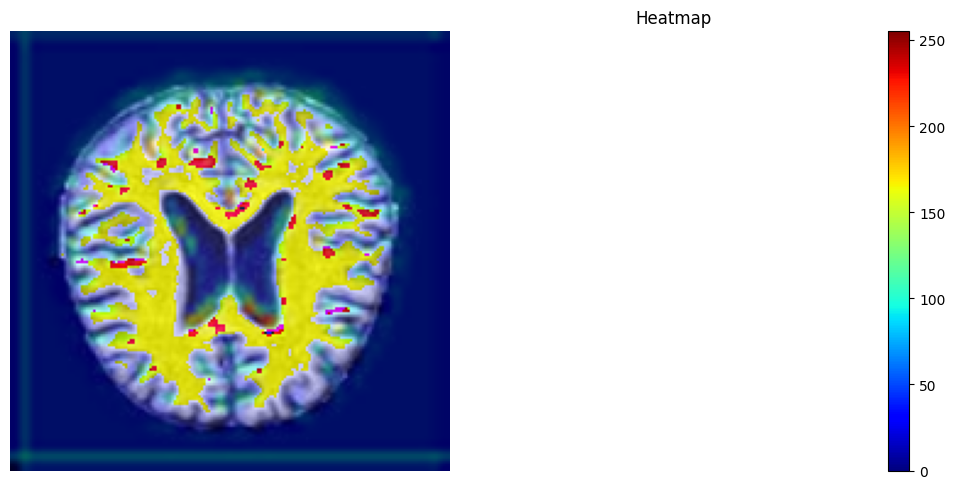

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

def get_gradcam_heatmap(model, img_array, layer_name, class_index):
    # Print the layers of the model to verify the layer name
    for layer in model.layers:
        print(layer.name, layer.output.shape)

    try:
        layer = model.get_layer(layer_name)
    except ValueError:
        print(f"Layer {layer_name} not found in the model.")
        return None

    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        print(f"conv_outputs shape: {conv_outputs.shape}, predictions shape: {predictions.shape}")
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    print(f"grads shape: {grads.shape}")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print(f"pooled_grads shape: {pooled_grads.shape}")

    conv_outputs = conv_outputs[0]
    conv_outputs = tf.nn.relu(conv_outputs)
    print(f"conv_outputs shape after relu: {conv_outputs.shape}")

    # Multiply each channel by its corresponding gradient
    conv_outputs = tf.einsum('ijk, k -> ijk', conv_outputs, pooled_grads)

    heatmap = tf.reduce_mean(conv_outputs, axis=-1).numpy()

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((180, 180))
    img = np.array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8)).resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = Image.fromarray(np.uint8(superimposed_img))
#
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(superimposed_img)
    ax[0].axis('off')

    # Plot the heatmap colorbar
    cbar = fig.colorbar(ax[0].imshow(superimposed_img, cmap='jet'), ax=ax[1], orientation='vertical')
    ax[1].axis('off')
    ax[1].set_title('Heatmap')

    plt.tight_layout()
    plt.show()
#
# Load and preprocess the image
img_path = '/content/drive/MyDrive/Internship IISc/Datasets/TestDataUnclassed/Copy of verymild.jpg'
img = Image.open(img_path).convert('RGB').resize((180, 180))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Print the model layers
print("Model layers:")
for layer in model.layers:
    print(layer.name)

# Specify the layer name and class index (usually the index of the class you want to visualize)
layer_name = 'conv2d_2'  # Replace with the name of the desired convolutional layer
class_index = np.argmax(model.predict(img_array))

heatmap = get_gradcam_heatmap(model, img_array, layer_name, class_index)
if heatmap is not None:
    display_gradcam(img_path, heatmap)


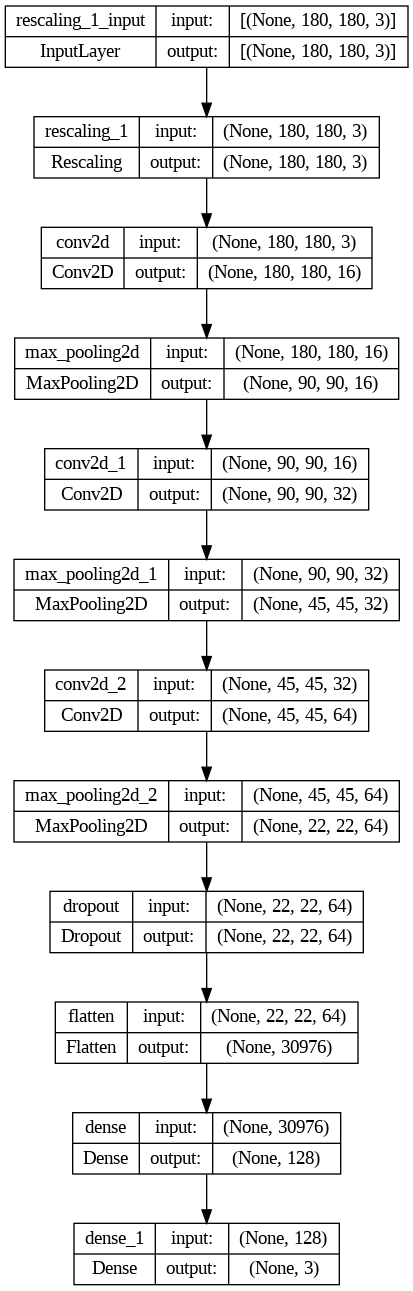

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True)